> ![](https://raw.githubusercontent.com/SunnySuite/Sunny.jl/main/assets/sunny_logo.jpg)

_This is a tutorial for the [Sunny](https://github.com/SunnySuite/Sunny.jl/) package, which enables dynamical simulations of ordered and thermally disordered spins with dipole and higher order moments._

## **Spin Dynamics of the Heisenberg pyrochlore antiferromagnet and applications to MgCr2O4**
#### Author: Martin Mourigal (mourigal@gatech.edu)
#### Date: 09/03/2022
#### Version: Julia 1.8, Sunny updated 09/03/2022

In this tutorial, we will walk through a first example in Su(n)ny and calculate the spin dynamical properties of the Heisenberg pyrochlore antiferromagnet and apply this knowledge to MgCr2O4 and ZnCr2O4 which are known to approximate that model. Relevant publications are here:

[1] P. H. Conlon and J. T. Chalker, Phys. Rev. Lett. 102, 237206 (2009) (https://doi.org/10.1103/PhysRevLett.102.237206)

[2] P. H. Conlon and J. T. Chalker, Phys. Rev. B 81, 224413 (2010) (https://doi.org/10.1103/PhysRevB.81.224413)

[3] X. Bai, J. A. M. Paddison, _et al._ Phys. Rev. Lett. 122, 097201 (2019) (https://doi.org/10.1103/PhysRevLett.122.097201)

## **Setting up Julia with the necessary packages**

Important ressources to get started:

https://github.com/SunnySuite/Sunny.jl/blob/main/GettingStarted.md      

https://sunnysuite.github.io/Sunny.jl/dev/library/#Library

https://github.com/ddahlbom/SunnyTutorials/blob/main/tutorials/FeI2_tutorial.ipynb

In [1]:
# === Loading Packages ===
import Sunny # The main package
import ProgressMeter, Statistics, Formatting, StaticArrays, LinearAlgebra, DelimitedFiles, OffsetArrays, Random # Some useful peripheral packages
import GLMakie, Plots # Some useful plotting packages
Sunny.offline_viewers(); 

## **Setting up the Crystal Structure for the Model and MgCr2O4**

This is the way theorists think about the pyrochlore lattice, and we are going to input this by hand in our system..

> ![](https://www.oist.jp/sites/default/files/photos/20200110-diagram-of-pyrochlore-lattice.jpg)

> _Picture Credits: Theory of Quantum Matter Unit, OIST_

#### "Theorist" Method ####

In [2]:
# === Define the crystal structure of a B-site pyrochlore lattice with only B-site atoms === 
lat_vecs = lattice_vectors(8.3342, 8.3342, 8.3342, 90.0, 90.0, 90.0);  
bas_vecs = [  [0.87500000, 0.62500000, 0.37500000],
              [0.62500000, 0.12500000, 0.62500000],
              [0.87500000, 0.87500000, 0.12500000],  
              [0.62500000, 0.87500000, 0.37500000],  
              [0.87500000, 0.12500000, 0.87500000],  
              [0.62500000, 0.62500000, 0.12500000],  
              [0.87500000, 0.37500000, 0.62500000],  
              [0.62500000, 0.37500000, 0.87500000],  
              [0.37500000, 0.62500000, 0.87500000],  
              [0.12500000, 0.12500000, 0.12500000],  
              [0.37500000, 0.87500000, 0.62500000],  
              [0.12500000, 0.87500000, 0.87500000],  
              [0.37500000, 0.12500000, 0.37500000],  
              [0.12500000, 0.62500000, 0.62500000],  
              [0.37500000, 0.37500000, 0.12500000],  
              [0.12500000, 0.37500000, 0.37500000]];
bas_typs = ["B","B","B","B", "B","B","B","B", "B","B","B","B", "B","B","B","B"]; 
xtal_pyro   = Crystal(lat_vecs, bas_vecs; types=bas_typs); # We will call this crystal the Theoretical Pyrochlore

# === Return crystalographic information gathered by Sunny about the crystal structure === 
display(xtal_pyro ); # Sunny can identify the space-group and point-group for this system. Here Fd-3m
view_crystal(xtal_pyro, 3.2) # Sunny can draw the crystal structure.

Crystal
HM symbol 'F d -3 m' (227)
Lattice params a=8.334, b=8.334, c=8.334, α=90°, β=90°, γ=90°
Cell volume 578.9
Type 'B', Wyckoff 16c (point group '.-3m'):
   1. [0.875, 0.625, 0.375]
   2. [0.625, 0.125, 0.625]
   3. [0.875, 0.875, 0.125]
   4. [0.625, 0.875, 0.375]
   5. [0.875, 0.125, 0.875]
   6. [0.625, 0.625, 0.125]
   7. [0.875, 0.375, 0.625]
   8. [0.625, 0.375, 0.875]
   9. [0.375, 0.625, 0.875]
   10. [0.125, 0.125, 0.125]
   11. [0.375, 0.875, 0.625]
   12. [0.125, 0.875, 0.875]
   13. [0.375, 0.125, 0.375]
   14. [0.125, 0.625, 0.625]
   15. [0.375, 0.375, 0.125]
   16. [0.125, 0.375, 0.375]


SunnyViewer(...)

Off course, a real crystal is more complicated and we will now construct the system using the actual .cif file of MgCr2O4 from ICSD. The first way you could do that is importing by hand the data from a .cif file, but this can be dangerous, as shown below:

#### "Experimentalist" Method #1 (Incorrect) ####

In [3]:
# === Define the crystal structure of MgCr2O4 by copying the info from a .cif file === 
lat_vecs     = lattice_vectors(8.3342, 8.3342, 8.3342, 90.0, 90.0, 90.0);  
bas_vecs     = [  [0.12500, 0.12500, 0.12500],
              [0.50000, 0.50000, 0.50000],
              [0.26070, 0.26070, 0.26070]]; 
bas_typs     = ["Mg","Cr","O"];
xtal_mgcro_1 = Crystal(lat_vecs, bas_vecs; types=bas_typs); 
display(xtal_mgcro_1); 

Crystal
HM symbol 'R 3 m' (160)
Lattice params a=8.334, b=8.334, c=8.334, α=90°, β=90°, γ=90°
Cell volume 578.9
Type 'Mg', Wyckoff 3a (point group '3m'):
   1. [0.125, 0.125, 0.125]
Type 'Cr', Wyckoff 3a (point group '3m'):
   2. [0.5, 0.5, 0.5]
Type 'O', Wyckoff 3a (point group '3m'):
   3. [0.2607, 0.2607, 0.2607]


Here, obviously, we are not getting the right space group for MgCr2O4. This can be achieved by modifying the input to include the space group and the setting.

#### "Experimentalist" Method #2 (Correct) ####

In [4]:
# === Define the crystal structure of MgCr2O4 by copying the info from a .cif file INCLUDING space group and setting === 

lat_vecs     = lattice_vectors(8.3342, 8.3342, 8.3342, 90.0, 90.0, 90.0);  
bas_vecs     = [ [0.12500, 0.12500, 0.12500],
                [0.50000, 0.50000, 0.50000],
                [0.26070, 0.26070, 0.26070]]; 
bas_typs     = ["Mg","Cr","O"];
lat_spg      = 227; # Space Group Number 
lat_set      = "2"; # Space Group setting
xtal_mgcro_2 = Crystal(lat_vecs, bas_vecs, lat_spg; types=bas_typs, setting=lat_set); 
display(xtal_mgcro_2);
#view_crystal(xtal_mgcro_2, 3.2) # Sunny can draw the crystal structure. 

Crystal
HM symbol 'F d -3 m' (227)
Lattice params a=8.334, b=8.334, c=8.334, α=90°, β=90°, γ=90°
Cell volume 578.9
Type 'Mg', Wyckoff 8b (point group '-43m'):
   1. [0.125, 0.125, 0.125]
   2. [0.625, 0.625, 0.125]
   3. [0.875, 0.375, 0.375]
   4. [0.375, 0.875, 0.375]
   5. [0.625, 0.125, 0.625]
   6. [0.125, 0.625, 0.625]
   7. [0.375, 0.375, 0.875]
   8. [0.875, 0.875, 0.875]
Type 'Cr', Wyckoff 16c (point group '.-3m'):
   9. [0.5, 0, 0]
   10. [0.75, 0.25, 0]
   11. [0, 0.5, 0]
   12. [0.25, 0.75, 0]
   13. [0.75, 0, 0.25]
   14. [0.5, 0.25, 0.25]
   15. [0.25, 0.5, 0.25]
   16. [0, 0.75, 0.25]
   17. [0, 0, 0.5]
   18. [0.25, 0.25, 0.5]
   19. [0.5, 0.5, 0.5]
   20. [0.75, 0.75, 0.5]
   21. [0.25, 0, 0.75]
   22. [0, 0.25, 0.75]
   23. [0.75, 0.5, 0.75]
   24. [0.5, 0.75, 0.75]
Type 'O', Wyckoff 32e (point group '.3m'):
   25. [0.7393, 0.0107, 0.0107]
   26. [0.5107, 0.2393, 0.0107]
   27. [0.2393, 0.5107, 0.0107]
   28. [0.0107, 0.7393, 0.0107]
   29. [0.5107, 0.0107, 0.2393]
  

This is correct, but at this point we might as well import the cif file directly, but sometimes the files are not formatted correctly!

#### "Experimentalist" Method #3 (Correct but watchout for bad .cif files) ####

In [5]:
# === Define the crystal structure of MgCr2O4 by importing a cif file === 
xtal_mgcro_3 = Crystal("MgCr2O4_9006236_1994.cif",symprec=0.001);
display(xtal_mgcro_3); 

LoadError: ArgumentError: column name :_atom_site_type_symbol not found in the data frame

Oh no! Our .cif file is not formatted correctly... Well, we can always work with our method where we enter the .cif information by hand. But just to show you:

In [6]:
# === Define the crystal structure of MgCr2O4 by importing a cif file === 
xtal_mgcro_3 = Crystal("MgCr2O4_160953_2009.cif",symprec=0.001);
display(xtal_mgcro_3);

Crystal
HM symbol 'F d -3 m' (227)
Lattice params a=8.333, b=8.333, c=8.333, α=90°, β=90°, γ=90°
Cell volume 578.6
Type 'Mg2+', Wyckoff 8b (point group '-43m'):
   1. [0.125, 0.125, 0.125]
   2. [0.625, 0.625, 0.125]
   3. [0.875, 0.375, 0.375]
   4. [0.375, 0.875, 0.375]
   5. [0.625, 0.125, 0.625]
   6. [0.125, 0.625, 0.625]
   7. [0.375, 0.375, 0.875]
   8. [0.875, 0.875, 0.875]
Type 'Cr3+', Wyckoff 16c (point group '.-3m'):
   9. [0.5, 0, 0]
   10. [0.75, 0.25, 0]
   11. [0, 0.5, 0]
   12. [0.25, 0.75, 0]
   13. [0.75, 0, 0.25]
   14. [0.5, 0.25, 0.25]
   15. [0.25, 0.5, 0.25]
   16. [0, 0.75, 0.25]
   17. [0, 0, 0.5]
   18. [0.25, 0.25, 0.5]
   19. [0.5, 0.5, 0.5]
   20. [0.75, 0.75, 0.5]
   21. [0.25, 0, 0.75]
   22. [0, 0.25, 0.75]
   23. [0.75, 0.5, 0.75]
   24. [0.5, 0.75, 0.75]
Type 'O2-', Wyckoff 32e (point group '.3m'):
   25. [0.7388, 0.0112, 0.0112]
   26. [0.5112, 0.2388, 0.0112]
   27. [0.2388, 0.5112, 0.0112]
   28. [0.0112, 0.7388, 0.0112]
   29. [0.5112, 0.0112, 0.23

#### Subcrystals ####

Finally, we constructing a spin Hamiltonian, it is useful to only consider the magnetic atoms in the unit-cell while keeping the symmetry correct for the determination of exchange and g-factor anisotropies. This is achieved below:

In [7]:
# === Define a sub crystal === 
xtal_mgcro = subcrystal(xtal_mgcro_2,"Cr");
display(xtal_mgcro); # Note the warming about renumbering atoms

WARNING, atoms are being renumbered.


Crystal
HM symbol 'F d -3 m' (227)
Lattice params a=8.334, b=8.334, c=8.334, α=90°, β=90°, γ=90°
Cell volume 578.9
Type 'Cr', Wyckoff 16c (point group '.-3m'):
   1. [0.5, 0, 0]
   2. [0.75, 0.25, 0]
   3. [0, 0.5, 0]
   4. [0.25, 0.75, 0]
   5. [0.75, 0, 0.25]
   6. [0.5, 0.25, 0.25]
   7. [0.25, 0.5, 0.25]
   8. [0, 0.75, 0.25]
   9. [0, 0, 0.5]
   10. [0.25, 0.25, 0.5]
   11. [0.5, 0.5, 0.5]
   12. [0.75, 0.75, 0.5]
   13. [0.25, 0, 0.75]
   14. [0, 0.25, 0.75]
   15. [0.75, 0.5, 0.75]
   16. [0.5, 0.75, 0.75]


## **Setting up the Single-Ion and Exchange Properties of our System, and build a Spin System** ##

Sunny can determine exchange and g-tensor anisotropies. This is achieved as follows:

#### Symmetry Analysis of Exchange and Single-Ion anisotropies ####

In [8]:
display("======== MgCr2O4 Exchange Interactions to Third Neighbor ========")
print_bond_table(xtal_mgcro, 6.0); # Print g-factor of Cr site and exchange interactions to distance of 6.0Å

"======== MgCr2O4 Exchange Interactions to Third Neighbor ========"

Atom 1, type 'Cr', position [0.5, 0, 0], multiplicity 16
Allowed single-ion anisotropy or g-tensor: | A  B  B |
                                           | B  A  B |
                                           | B  B  A |

Bond(1, 2, [0, 0, 0])
Distance 2.9466, coordination 6
Connects 'Cr' at [0.5, 0, 0] to 'Cr' at [0.75, 0.25, 0]
Allowed exchange matrix: | A  C -D |
                         | C  A -D |
                         | D  D  B |
Allowed DM vector: [-D D 0]

Bond(1, 7, [0, 0, 0])
Distance 5.1036, coordination 12
Connects 'Cr' at [0.5, 0, 0] to 'Cr' at [0.25, 0.5, 0.25]
Allowed exchange matrix: |   A  C-E  D-F |
                         | C+E    B -C+E |
                         | D+F -C-E    A |
Allowed DM vector: [E F -E]

Bond(1, 3, [0, 0, 0])
Distance 5.8932, coordination 6
Connects 'Cr' at [0.5, 0, 0] to 'Cr' at [0, 0.5, 0]
Allowed exchange matrix: | A  D  C |
                         | D  A  C |
                         | C  C  B |

Bond(1, 3, [1, 0, 0])
Distance 5.8932,

In [9]:
display("======== MgCr2O4 Allowed single-ion anisotropy ========")
print_allowed_anisotropy(xtal_mgcro, 1);

"======== MgCr2O4 Allowed single-ion anisotropy ========"

# Stevens operators at various orders k
𝒪₂ = stevens_operators(N, 2)
𝒪₄ = stevens_operators(N, 4)
𝒪₆ = stevens_operators(N, 6)

# Allowed anisotropies
A₂(𝒪₂[-2]+2𝒪₂[-1]+2𝒪₂[1])
A₄(7𝒪₄[-3]+2𝒪₄[-2]-𝒪₄[-1]-𝒪₄[1]-7𝒪₄[3]) + B₄(𝒪₄[0]+5𝒪₄[4])
A₆(11𝒪₆[-6]+8𝒪₆[-3]-𝒪₆[-2]+8𝒪₆[-1]+8𝒪₆[1]-8𝒪₆[3]) + B₆((33/2)𝒪₆[-5]+(-9/2)𝒪₆[-3]+4𝒪₆[-2]+𝒪₆[-1]+𝒪₆[1]+(9/2)𝒪₆[3]+(33/2)𝒪₆[5]) + C₆(𝒪₆[0]-21𝒪₆[4])


In [10]:
display("======== Pyrochlore Lattice Exchange Interactions to Third Neighbor ========")
print_bond_table(xtal_pyro, 5.9); # Print g-factor of pyrochlore and exchange interactions to distance of 4.0Å

"======== Pyrochlore Lattice Exchange Interactions to Third Neighbor ========"

Atom 1, type 'B', position [0.875, 0.625, 0.375], multiplicity 16
Allowed single-ion anisotropy or g-tensor: | A  B -B |
                                           | B  A  B |
                                           |-B  B  A |

Bond(1, 3, [0, 0, 0])
Distance 2.9466, coordination 6
Connects 'B' at [0.875, 0.625, 0.375] to 'B' at [0.875, 0.875, 0.125]
Allowed exchange matrix: | A -D  D |
                         | D  B  C |
                         |-D  C  B |
Allowed DM vector: [0 -D -D]

Bond(1, 2, [0, 0, 0])
Distance 5.1036, coordination 12
Connects 'B' at [0.875, 0.625, 0.375] to 'B' at [0.625, 0.125, 0.625]
Allowed exchange matrix: |   A  C-E  D-F |
                         | C+E    B -C+E |
                         | D+F -C-E    A |
Allowed DM vector: [E F -E]

Bond(2, 6, [0, 0, 0])
Distance 5.8932, coordination 6
Connects 'B' at [0.625, 0.125, 0.625] to 'B' at [0.625, 0.625, 0.125]
Allowed exchange matrix: | A  D  D |
                         | D  B  C |
                      

Note that the exchange anisotropies of the Pyrochlore model are slightly different from that of MgCr2O4, due to the role of Mg and O in the bonds. Also note that the program indentifies correctly the two inequivalent bonds 3a and 3b having the same length. A question may arises to know which bond is J3a and which is J3b, let's plot the structure:

In [ ]:
#view_crystal(xtal_mgcro, 5.9) # Sunny can draw the crystal structure. 

SunnyViewer(...)

The above plot shows that the second interaction (cyan color) with the distance of 5.89Å is in fact the one hopping through a Chromium site, meaning it is J3a! So we need to be careful with that later.

#### Building the local Hilbert Space for our system ####

In [11]:
# === Define Local Hilbert Space for Cr ===
lhs_Cr  = [SiteInfo(1; N=0, g=2.0, spin_rescaling=3/2)];  # Local Hilbert Space for a spin-3/2 treated classically (N=0) and with g=2. If all the operators of the local S=3/2 operators have to be retained, this corresponds to N=4.
lhs_B   = [SiteInfo(1; N=0, g=2.0, spin_rescaling=3/2)]; 

#### Building the exchange interactions for our system ####

In [12]:
# === Define Values of Exchange Interactions ===
val_J1      = 3.27; # value of J1 in meV from Bai's PRL paper
val_J_pyro  = [1.00,0.000,0.000,0.000]*val_J1; # pure nearest neighbor pyrochlore
val_J_mgcro = [1.00,0.0815,0.1050,0.0085]*val_J1; # further neighbor pyrochlore relevant for MgCr2O4
#val_J_mgcro = [1.00,0.000,0.025,0.025]*val_J1; # this is a funny setting from Conlon-Chalker

# === Build list of exchange interactions for our system ===
exint_pyro  = [heisenberg(val_J_pyro[1],  Bond(1, 3, [0, 0, 0]),"J1"),
               heisenberg(val_J_pyro[2],  Bond(1, 2, [0, 0, 0]),"J2"), 
               heisenberg(val_J_pyro[3],  Bond(2, 6, [0, 0, 0]),"J3a"), 
               heisenberg(val_J_pyro[4],  Bond(1, 5, [0, 0, 0]),"J3b")];
exint_mgcro = [heisenberg(val_J_mgcro[1], Bond(1, 2, [0, 0, 0]),"J1"),
               heisenberg(val_J_mgcro[2], Bond(1, 7, [0, 0, 0]),"J2"),
               heisenberg(val_J_mgcro[3], Bond(1, 3, [0, 0, 0]),"J3a"),   # Watch out for which is J3a see above plots
               heisenberg(val_J_mgcro[4], Bond(1, 3, [1, 0, 0]),"J3b")];   # Watch out for which is J3b see above plots           

#### Building the spin system ####

In [19]:
## === Define Super Cell Size ===
scd  = (6,6,6); #Super Cell Dimension Let's go small for now

## === Construct the Spin Systems ===
sys_pyro  = SpinSystem(xtal_pyro,  exint_pyro,  scd, lhs_B);
sys_mgcro = SpinSystem(xtal_mgcro, exint_mgcro, scd, lhs_Cr);

## === Randomize the Spins ===
rand!(sys_pyro);
rand!(sys_mgcro);

## **Cooling our System amd Calculating the Structure Factor for that temperature** ##

#### Setting up a Langevin Sampler (and optionally a Metropolis one) ####

In [36]:
## === Construct Langevin Sampler ===
nLA = 10;  # Number of Langevin time steps performed each time the Sampler is invoked
α   = 0.1; # Langevin damping, usually 0.05 or 0.1 is good.
Δt  = 0.01; # Time steps in Langevin
kT  = val_J1*20; # Initializing spin system at some finite temperature corresponding to 10 times J1 (to be well paramagnetic)
sam_LA_pyro  = LangevinSampler(sys_pyro, kT, α, Δt, nLA);
sam_LA_mgcro = LangevinSampler(sys_mgcro, kT, α, Δt, nLA);

## === Optional: Construct Metropolis Sampler ===
nMC = 5;  # Number of Langevin time steps performed each time the Sampler is invoked
kT  = val_J1*20; # Initializing spin system at some finite temperature corresponding to 10 times J1 (to be well paramagnetic)
sam_MC_pyro  = MetropolisSampler(sys_pyro, kT, nMC);
sam_MC_mgcro = MetropolisSampler(sys_mgcro, kT, nMC);


In [41]:
## === Thermalize System to the temperature said below using Langevin===
kT     = 1.8; # Target temperature in meV
nTherm = 1000; # Number of times the Sampler will run, here nLA*nTherm
@time begin
    set_temp!(sam_LA_pyro,kT); 
    set_temp!(sam_LA_mgcro,kT); 
    set_temp!(sam_MC_pyro,kT); 
    set_temp!(sam_MC_mgcro,kT); 
    prog = Progress(Int64(round(nTherm/100)); dt=0.10, desc="Thermalizing: ", color=:blue)
    for j in 1:nTherm/100
        thermalize!(sam_LA_pyro,Int64(round(nTherm/100)));
        thermalize!(sam_MC_pyro,Int64(round(nTherm/100)));
        thermalize!(sam_LA_mgcro,Int64(round(nTherm/100)));
        thermalize!(sam_MC_mgcro,Int64(round(nTherm/100)));
        next!(prog);  
    end
end

Thermalizing: 100%|█████████████████████████████████████| Time: 0:00:08


  8.342803 seconds (49.86 M allocations: 6.665 GiB, 13.56% gc time)


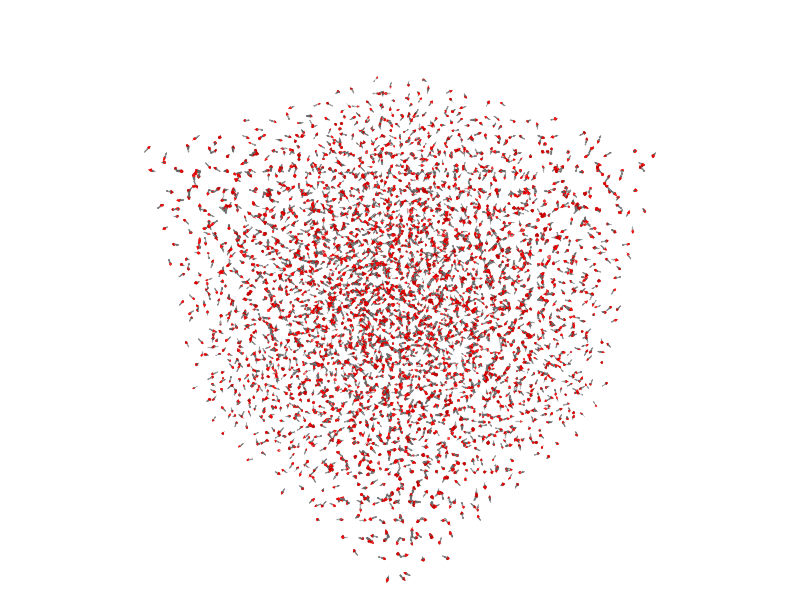

In [38]:
## === Plot the resulting spin system for the Pyrochlore ===
plot_spins(sys_pyro,arrowlength=0.5, linewidth=0.2, arrowsize=0.5)

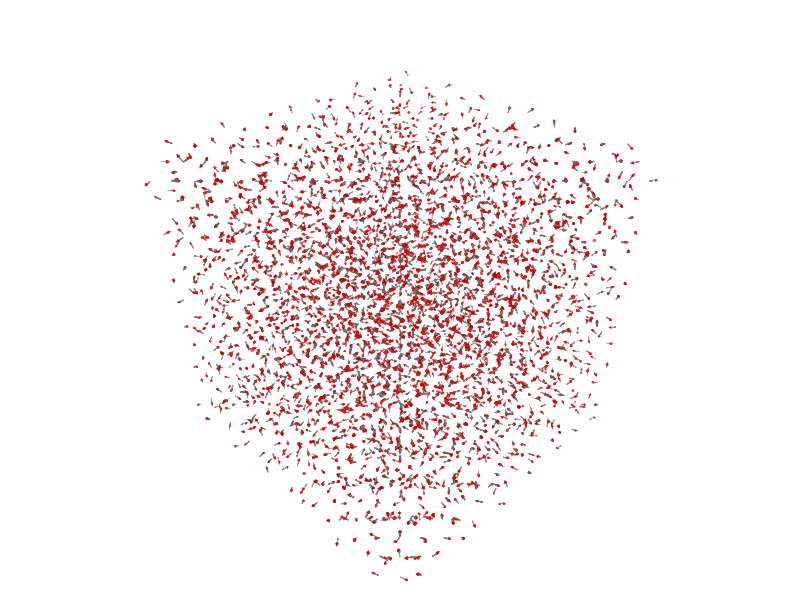

In [42]:
## === Plot the resulting spin system for the MgCr2O4 ===
plot_spins(sys_mgcro,arrowlength=0.5, linewidth=0.2, arrowsize=0.5)

#### Calculating the Structure Factor ####

In [43]:
##  === Calculate SQ ===
nsam        = 10; # Number of samples that are averaged over  (usually 10 is good)
decor_ratio = 10; # Number of time the Sampler is called to decorelate samples between sampling
bz_size     = (8,8,8); # Size of the resulting extended Brillouin zone after FFT
@time begin
    sq_pyro  = StructureFactor(sys_pyro; bz_size=bz_size, dipole_factor=true)
    sq_mgcro = StructureFactor(sys_mgcro; bz_size=bz_size, dipole_factor=true)
    prog     = Progress(nsam ; dt=1.00, desc="Sampling: ", color=:green)
    for j in 1:nsam
        thermalize!(sam_LA_pyro,decor_ratio); 
        thermalize!(sam_LA_mgcro,decor_ratio); 
        Sunny.update!(sq_pyro,sys_pyro)
        Sunny.update!(sq_mgcro,sys_mgcro);
        next!(prog);        
    end
end

Sampling: 100%|█████████████████████████████████████████| Time: 0:06:54


415.289282 seconds (132.71 M allocations: 253.720 GiB, 15.15% gc time)


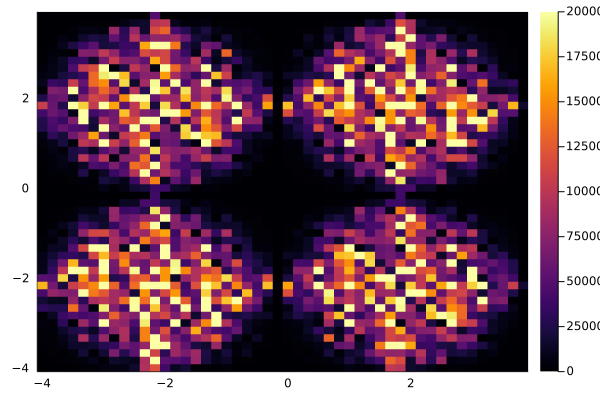

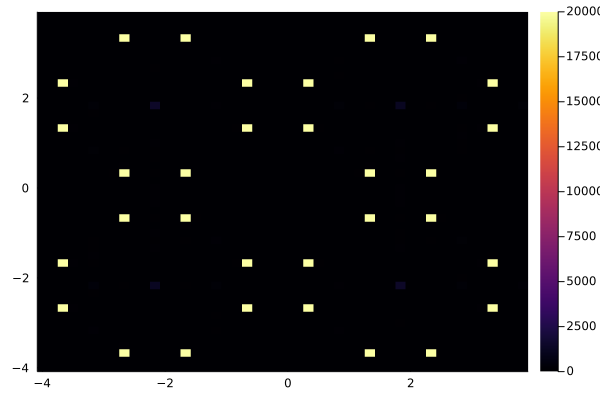

In [35]:
#  === Create a function to plot S(Q) ===
function PlotSQ(input_sq, input_sys; Slice, Imax)
    Q1   = range(input_sq.sfactor.offsets[1],length=size(input_sq.sfactor)[1])/size(input_sys.lattice)[1];
    Q2   = range(input_sq.sfactor.offsets[2],length=size(input_sq.sfactor)[2])/size(input_sys.lattice)[2];
    Q3   = range(input_sq.sfactor.offsets[3],length=size(input_sq.sfactor)[3])/size(input_sys.lattice)[3];
    midQ = Int64(size(Q1)[1]/2);
    Int = input_sq.sfactor[:,:,Slice,0]/prod(size(input_sys.lattice));
    return display(Plots.heatmap(Q1,Q2,Int,clim=(0,Imax)));   
end
    
#  === Plot the Results ===
PlotSQ(sq_pyro, sys_pyro; Slice=0, Imax=2000000)
PlotSQ(sq_mgcro, sys_mgcro; Slice=0, Imax=20000)
    

## **Calculating the Dynamical Structure Factor** ##


In [ ]:
#  === Calculate SQW ===
Nω   = 100;  # Number of Frequencies Calculated
ωmax = val_J1*15;
Δt   = 0.001;
nsam = 2;  # Number of samples that are averaged over  (usually 10 is good)
nLa  = 20;
bz_size = (8,8,8);
@time begin
sqw_pyro = dynamic_structure_factor(sys_pyro, sam_LA_pyro; 
    dynΔt=Δt, meas_rate=convert(Int64,round(2*pi/(Δt*ωmax))), dyn_meas=Nω,
    bz_size=bz_size, 
    thermalize=nLa,nsamples=nsam,  
    verbose=true, reduce_basis=true, dipole_factor=true,
)
end
@time begin
sqw_mgcro = dynamic_structure_factor(sys_mgcro, sam_LA_mgcro; 
    dynΔt=Δt, meas_rate=convert(Int64,round(2*pi/(Δt*ωmax))), dyn_meas=Nω,
    bz_size=bz_size, 
    thermalize=nLa,nsamples=nsam,  
    verbose=true, reduce_basis=true, dipole_factor=true,
)
end

#  === Create a function to plot S(Q,W) ===
function PlotSQW(input_sqw, input_sys; Slice1, Slice2, Imax)
    Q1   = range(input_sqw.sfactor.offsets[1],length=size(input_sqw.sfactor)[1])/size(input_sys.lattice)[1];
    Q2   = range(input_sqw.sfactor.offsets[2],length=size(input_sqw.sfactor)[2])/size(input_sys.lattice)[2];
    Q3   = range(input_sqw.sfactor.offsets[3],length=size(input_sqw.sfactor)[3])/size(input_sys.lattice)[3];
    EN   = range(input_sqw.sfactor.offsets[4],length=size(input_sqw.sfactor)[4]);
    midQ = Int64(size(Q1)[1]/2);
    midE = Int64(size(EN)[1]/2);
    Int  = input_sqw.sfactor[:,Slice1,Slice2,:]/prod(size(input_sys.lattice));
    return display(Plots.heatmap(Q1,EN[1:midE],Int[:,Slice1,Slice2,1:midE]',clim=(0,Imax)));   
end

LoadError: UndefVarError: val_J1 not defined

In [ ]:
#  === Plot the Results ===
PlotSQW(sqw_pyro, sys_pyro; Slice1=0, Slice2=0, Imax=200);
PlotSQW(sqw_mgcro, sys_mgcro; Slice1=0, Slice2=0, Imax=200);